In [1]:
import pandas as pd
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

pre_trained = "bert-base-german-cased"

### Hyperparameters


In [2]:
epochs = 40
batch_size = 30
drop_out = 0.25

# DataSet

In [3]:
dataset = pd.read_csv('/kaggle/input/discharge-letter/Discharge_letter_dataset.csv')  

In [4]:
possible_labels = dataset.Category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'-': 0, 'MH': 1, 'D': 2, 'TP': 3, 'S': 4, 'DP': 5}

In [5]:
tokenizer = BertTokenizer.from_pretrained(pre_trained, 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='train'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='val'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dataset[dataset.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(dataset[dataset.data_type=='val'].label.values)


Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Splitting dataset (Train, Test)

In [6]:

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [7]:
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      attention_probs_dropout_prob = drop_out,
                                                      hidden_dropout_prob = drop_out
)
model.cuda()

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.25, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.25, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

# Setting model parameters

In [8]:

OverAll_f1 = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

optimizer = AdamW(model.parameters(),lr=1e-5, eps=1e-8)


scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# Accuracy metric


In [9]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    Accuracy = 0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        #print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        Accuracy += len(y_preds[y_preds==label])/len(y_true)
    return (Accuracy/6)

# Training

In [10]:
import random

train_loss_dict = {}
val_loss_dict = {}
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/kaggle/working/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    OverAll_f1.append((epoch,val_f1))
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    train_loss_dict[epoch] = loss_train_avg
    val_loss_dict[epoch] = val_loss


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.5678175584129665
Validation loss: 1.2900110483169556
F1 Score (Weighted): 0.4068534644983681


Epoch 2:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.2604175499383954
Validation loss: 1.070247613466703
F1 Score (Weighted): 0.5330298982455025


Epoch 3:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.079942910567574
Validation loss: 0.9147991079550523
F1 Score (Weighted): 0.6705650972696245


Epoch 4:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.9333308071329973
Validation loss: 0.8804934758406419
F1 Score (Weighted): 0.6541379290349464


Epoch 5:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.8453266301016876
Validation loss: 0.8275081836260282
F1 Score (Weighted): 0.6927600923668684


Epoch 6:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.739683847496475
Validation loss: 0.8015872285916255
F1 Score (Weighted): 0.7076364084786025


Epoch 7:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.6613070161446281
Validation loss: 0.7797094193788675
F1 Score (Weighted): 0.724766392141028


Epoch 8:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.6111612073753191
Validation loss: 0.7771538988902018
F1 Score (Weighted): 0.7264382940471816


Epoch 9:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.5634252562902976
Validation loss: 0.7671324003201264
F1 Score (Weighted): 0.7303184829604308


Epoch 10:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.4952345909415812
Validation loss: 0.8082643495156214
F1 Score (Weighted): 0.717920634959989


Epoch 11:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.4348229267027067
Validation loss: 0.8032820448279381
F1 Score (Weighted): 0.75107343127283


Epoch 12:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.4124003348575122
Validation loss: 0.7997373038759599
F1 Score (Weighted): 0.7462564387488059


Epoch 13:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.3929295218077259
Validation loss: 0.8831064534875063
F1 Score (Weighted): 0.7341692420924224


Epoch 14:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.365958039527354
Validation loss: 0.8448261816341144
F1 Score (Weighted): 0.7510607310611302


Epoch 15:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.3170302892508714
Validation loss: 0.8796513137909082
F1 Score (Weighted): 0.7432063014961106


Epoch 16:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.28510856725599454
Validation loss: 0.9044634645374922
F1 Score (Weighted): 0.7441350961838112


Epoch 17:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.2791614736551824
Validation loss: 0.9451486273453786
F1 Score (Weighted): 0.744400824773753


Epoch 18:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.2507633388690326
Validation loss: 0.9102216457518247
F1 Score (Weighted): 0.7481131813460316


Epoch 19:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.23402048188491145
Validation loss: 0.9389319623319002
F1 Score (Weighted): 0.7521798978430516


Epoch 20:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.2183433849958406
Validation loss: 0.9793452894171844
F1 Score (Weighted): 0.7487610620778877


Epoch 21:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 21
Training loss: 0.22639639513648074
Validation loss: 0.9714576622041372
F1 Score (Weighted): 0.7501639978652308


Epoch 22:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 22
Training loss: 0.19667437343277794
Validation loss: 1.030670371479713
F1 Score (Weighted): 0.7498586322261171


Epoch 23:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 23
Training loss: 0.18025707377903705
Validation loss: 1.0346287622188146
F1 Score (Weighted): 0.7391038185168034


Epoch 24:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 24
Training loss: 0.1653400051097075
Validation loss: 1.0890265408043678
F1 Score (Weighted): 0.7252630893663357


Epoch 25:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 25
Training loss: 0.18184538274679496
Validation loss: 1.0450505536192884
F1 Score (Weighted): 0.7492014829886645


Epoch 26:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 26
Training loss: 0.1724087652898785
Validation loss: 1.0609451839700341
F1 Score (Weighted): 0.7510986259336002


Epoch 27:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 27
Training loss: 0.16798275834678308
Validation loss: 1.0885168744537692
F1 Score (Weighted): 0.7323444962112363


Epoch 28:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 28
Training loss: 0.1535343635233416
Validation loss: 1.087890568977365
F1 Score (Weighted): 0.7318488555643251


Epoch 29:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 29
Training loss: 0.15231593169163968
Validation loss: 1.0931208268381083
F1 Score (Weighted): 0.7379987346949388


Epoch 30:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 30
Training loss: 0.14328490702462368
Validation loss: 1.1009172163903713
F1 Score (Weighted): 0.7167916747300929


Epoch 31:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 31
Training loss: 0.1420839274086166
Validation loss: 1.1100404172992477
F1 Score (Weighted): 0.7322231976237501


Epoch 32:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 32
Training loss: 0.13834410742519127
Validation loss: 1.1250882447482302
F1 Score (Weighted): 0.7362008901803662


Epoch 33:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 33
Training loss: 0.12813988545288643
Validation loss: 1.124734360867968
F1 Score (Weighted): 0.7187247396335343


Epoch 34:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 34
Training loss: 0.11629228094133778
Validation loss: 1.1522905060018485
F1 Score (Weighted): 0.7297294066631337


Epoch 35:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 35
Training loss: 0.13063311327140834
Validation loss: 1.1269496148452163
F1 Score (Weighted): 0.7361151350041425


Epoch 36:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 36
Training loss: 0.12160270915542176
Validation loss: 1.1620180474307675
F1 Score (Weighted): 0.7382264496843864


Epoch 37:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 37
Training loss: 0.10840741289860528
Validation loss: 1.1638611803332775
F1 Score (Weighted): 0.7412810857415443


Epoch 38:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 38
Training loss: 0.10345878611332264
Validation loss: 1.1527832402632787
F1 Score (Weighted): 0.7420321044090757


Epoch 39:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 39
Training loss: 0.09726762253305186
Validation loss: 1.1635371158615901
F1 Score (Weighted): 0.7446126366756688


Epoch 40:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 40
Training loss: 0.1208432740666836
Validation loss: 1.1619042962646255
F1 Score (Weighted): 0.7411719759372871


# Testing best model

In [11]:
print(OverAll_f1)
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.cuda()
total_acc = []
for i in range(epochs):
    model.load_state_dict(torch.load(f'/kaggle/working/finetuned_BERT_epoch_{i+1}.model', map_location=torch.device('cuda')))

    _, predictions, true_vals = evaluate(dataloader_validation)
    accuracy = accuracy_per_class(predictions, true_vals)
    total_acc.append((accuracy, i+1))
print(total_acc)

[(1, 0.4068534644983681), (2, 0.5330298982455025), (3, 0.6705650972696245), (4, 0.6541379290349464), (5, 0.6927600923668684), (6, 0.7076364084786025), (7, 0.724766392141028), (8, 0.7264382940471816), (9, 0.7303184829604308), (10, 0.717920634959989), (11, 0.75107343127283), (12, 0.7462564387488059), (13, 0.7341692420924224), (14, 0.7510607310611302), (15, 0.7432063014961106), (16, 0.7441350961838112), (17, 0.744400824773753), (18, 0.7481131813460316), (19, 0.7521798978430516), (20, 0.7487610620778877), (21, 0.7501639978652308), (22, 0.7498586322261171), (23, 0.7391038185168034), (24, 0.7252630893663357), (25, 0.7492014829886645), (26, 0.7510986259336002), (27, 0.7323444962112363), (28, 0.7318488555643251), (29, 0.7379987346949388), (30, 0.7167916747300929), (31, 0.7322231976237501), (32, 0.7362008901803662), (33, 0.7187247396335343), (34, 0.7297294066631337), (35, 0.7361151350041425), (36, 0.7382264496843864), (37, 0.7412810857415443), (38, 0.7420321044090757), (39, 0.7446126366756688),

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

[(0.3671179713825536, 1), (0.4648713430543405, 2), (0.6177546428001507, 3), (0.6125795300162827, 4), (0.6527868279791306, 5), (0.663829326381249, 6), (0.6812853863810603, 7), (0.6799999398267546, 8), (0.689305796853186, 9), (0.6778900267818857, 10), (0.712198792553501, 11), (0.7055614944902159, 12), (0.698195435986491, 13), (0.7122965741917895, 14), (0.7115570886879731, 15), (0.6978804522030605, 16), (0.7057934586350944, 17), (0.7069658616514465, 18), (0.7077472891195306, 19), (0.7010674950452759, 20), (0.7045877491784588, 21), (0.7125603710355962, 22), (0.7030121774124688, 23), (0.6841515557918983, 24), (0.7053700409365268, 25), (0.7081897986156194, 26), (0.6892207430799117, 27), (0.6890165616612084, 28), (0.6950708037893075, 29), (0.6742364544320961, 30), (0.6880725844954068, 31), (0.6911028875257098, 32), (0.6758704413602007, 33), (0.687483821879193, 34), (0.6938955197301068, 35), (0.6957174947040997, 36), (0.6995512284611071, 37), (0.6996541627337214, 38), (0.7017781007647058, 39),

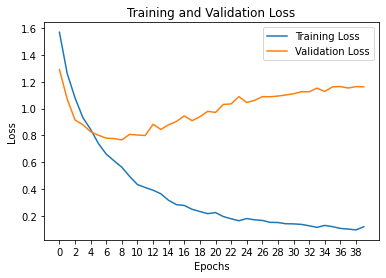

In [12]:
from matplotlib.pylab import plt
from numpy import arange


# Retrieve each dictionary's values
train_values = train_loss_dict.values()
val_values = val_loss_dict.values()

# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(0, epochs)


# Plot and label the training and validation loss values
plt.plot(epochs_range, train_values, label='Training Loss')
plt.plot(epochs_range, val_values, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, epochs, 2))

# Display the plot
plt.legend(loc='best')
plt.show()